In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import os
from tqdm import tqdm

# *Fun*-ctions

In [10]:
def hdf_to_df(hdf5_file_path: str) -> None:
    """
    """
    with pd.HDFStore(hdf5_file_path, mode='r') as store:
        available_keys = store.keys()
        for key in available_keys:
            if "w" in key or "v_inner" in key:
                key = key.split("/model/")[0]
                yield key


In [11]:
def interpolate_to_length(data, length):
    old_indices = np.arange(len(data))
    new_indices = np.linspace(0, len(data)-1, length)
    return np.interp(new_indices, old_indices, data)

In [16]:
def interpolate_data(hdf5_file_path: str, n_elem: int, key: str) -> pd.DataFrame:
    """
    """
    v_inner = pd.read_hdf(hdf5_file_path, key=f'{key}/model/v_inner').to_numpy()
    v_outer = pd.read_hdf(hdf5_file_path, key = f'{key}/model/v_outer').to_numpy()
    w_data = pd.read_hdf(hdf5_file_path, key=f'{key}/model/w').to_numpy()

    
    v_inner_interp = interpolate_to_length(v_inner, n_elem)
    v_outer_interp = interpolate_to_length(v_outer, n_elem)
    w_interp = interpolate_to_length(w_data, 40)
    
    dv = (v_outer_interp -v_inner_interp)[:-1]
    
    v = np.concatenate((v_inner[:1], dv)) #revert back to v_inner using np.cumsum on v

    col_names_v = [f'v_{i+1}' for i in range(len(v))]
    col_names_w = [f'w_{i+1}' for i in range(len(w_interp))]

    df_v = pd.DataFrame(v).T
    df_w = pd.DataFrame(w_interp).T

    df_v.columns = col_names_v
    df_w.columns = col_names_w

    df = pd.concat([df_v, df_w], axis=1)

    return df


In [5]:
def process_data(hdf5_file_path: str, n_elem: int) -> pd.DataFrame:
    """
    """
    keys = list(hdf_to_df(hdf5_file_path))

    keys = list(dict.fromkeys(keys))

    result_df = pd.DataFrame()
    
    for key in keys:
        df = interpolate_data(hdf5_file_path, n_elem, key)
        result_df = pd.concat([result_df, df], ignore_index=True)
    
    return result_df


# Extracting tar files

In [5]:
#import tarfile

#file_path = "../../data/emulator/hdf5-1.14.1-2-Std-centos8_64.tar.gz"

#destination_folder = "../../"

#with tarfile.open(file_path, "r:gz") as tar:
#    tar.extractall(path=destination_folder)


# Combine and Export data to Feather

In [30]:
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

list_of_sims = os.listdir("../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/")
file_path = '../../data/emulator/mnt/gs21/scratch/obrie278/Outputs/2022Emulator/Simulations/'

def process_file(hdf5_file):
    hdf5_file_path = file_path + hdf5_file
    return process_data(hdf5_file_path, 40)

max_threads = 6
dataframes = []  

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = [executor.submit(process_file, hdf5_file) for hdf5_file in list_of_sims]
    for future in tqdm(as_completed(futures), total=len(list_of_sims), desc="Processing Data", unit="file"):
        df_temp = future.result()
        dataframes.append(df_temp) 

df = pd.concat(dataframes) 

Processing Data: 100%|█████████████████████████████████████████████████████████| 1000/1000 [1:12:20<00:00,  4.34s/file]


In [38]:
df.reset_index()

,index,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40
0,0,1.443119e+09,1.230241e+07,3.580028e+07,5.248197e+07,5.358383e+07,5.470972e+07,5.585106e+07,5.702974e+07,5.822118e+07,...,0.106668,0.103144,0.099819,0.096413,0.093012,0.089911,0.086863,0.083897,0.081009,0.078155
1,1,1.273128e+09,1.481055e+07,3.194642e+07,4.192044e+07,4.277939e+07,4.366271e+07,4.455851e+07,4.547376e+07,4.641145e+07,...,0.239514,0.230244,0.221647,0.213360,0.205520,0.197961,0.190609,0.183795,0.177177,0.170712
2,2,1.294317e+09,8.739798e+06,3.075082e+07,4.347865e+07,4.439151e+07,4.533092e+07,4.628393e+07,4.725814e+07,4.825683e+07,...,0.090599,0.086867,0.083654,0.080591,0.077591,0.074747,0.072003,0.069456,0.066967,0.064525
3,3,1.230407e+09,4.482057e+06,3.041063e+07,4.248213e+07,4.347170e+07,4.449104e+07,4.553344e+07,4.659534e+07,4.768508e+07,...,0.182205,0.175015,0.168200,0.161533,0.155113,0.148809,0.142597,0.136756,0.131203,0.125950
4,4,1.168180e+09,3.679483e+06,2.068325e+07,3.042495e+07,3.092403e+07,3.143443e+07,3.195059e+07,3.247573e+07,3.301115e+07,...,0.117543,0.113594,0.109825,0.106189,0.102830,0.099594,0.096430,0.093361,0.090402,0.087527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233924,175,1.145226e+09,2.019068e+07,3.532901e+07,4.123646e+07,4.229688e+07,4.338248e+07,4.450455e+07,4.565218e+07,4.682579e+07,...,0.134573,0.128429,0.122767,0.117608,0.112739,0.108036,0.103525,0.099254,0.095228,0.091462
233925,176,8.562695e+08,2.925810e+07,3.043147e+07,3.143735e+07,3.246424e+07,3.352459e+07,3.461946e+07,3.574999e+07,3.691732e+07,...,0.110324,0.103343,0.097205,0.091929,0.086887,0.082052,0.077639,0.073486,0.069644,0.065973
233926,177,1.023729e+09,1.048212e+07,2.956088e+07,3.443972e+07,3.535914e+07,3.630191e+07,3.726856e+07,3.826268e+07,3.928619e+07,...,0.054064,0.051453,0.049009,0.046671,0.044515,0.042462,0.040495,0.038592,0.036760,0.035051
233927,178,8.030305e+08,1.594077e+07,1.942119e+07,1.988175e+07,2.035323e+07,2.083588e+07,2.132999e+07,2.183581e+07,2.235363e+07,...,0.129214,0.123674,0.118847,0.113717,0.108685,0.104648,0.100455,0.096008,0.091588,0.088062


In [40]:
df.reset_index().to_feather("../../data/full_data.feather")

In [17]:
y_vec= pd.read_feather("../Data/trainingData/full_data.feather")

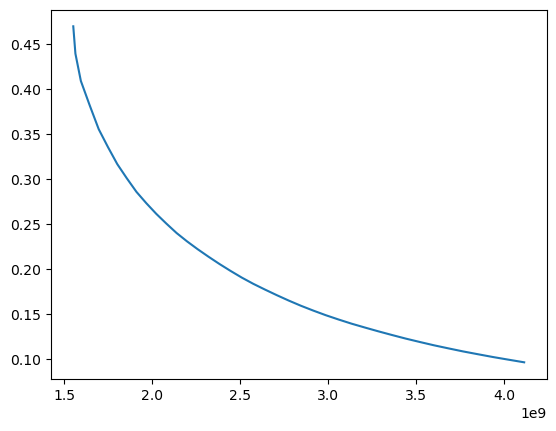

In [26]:
plt.plot(np.cumsum(df.iloc[0,:40]), df.iloc[0,40:]) # row 20 is a bit odd... not sure if that is right

# Extracting all X variables

## View the keys and columns of the h5 file

In [2]:
file_path = "../Data/datahub/test_dalek_data.h5"

In [4]:
!pip install tables

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.0 MB 17.6 MB/s            
     |████████████████████████████████| 378 kB 56.2 MB/s            
     |████████████████████████████████| 14.8 MB 52.3 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.6
    Uninstalling numpy-1.16.6:
      Successfully uninstalled numpy-1.16.6
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
atm 0.2.2 requires numpy<1.17,>=1.13.1, but you have numpy 1.19.5 which is incompatible.
torchvision 0.8.2 requires torch==1.7.1, but you have torch 1.10.2 

In [5]:
parameters = pd.read_hdf(file_path, key="parameters")
meta = pd.read_hdf(file_path, key="meta")

In [8]:
parameters.shape

(252129, 30)

In [10]:
parameters.to_csv("parameters.csv")

In [9]:
pd.read_csv("parameters.csv")

,Unnamed: 0,si,ca,s,mg,ni56,cr,ti,fe,o,...,m_ige,m_ube,M_tot,M_v_inner,normalization,v_max,converged,m_ige_quality,m_ube_quality,L_bol
0,0,0.017611,0.000146,0.003103,0.004542,0.000019,7.056800e-07,2.588982e-06,1.854508e-06,0.009264,...,0.000024,0.036336,0.061763,0.042842,1.403634e+53,8.118286e+08,1.0,-7.993606e-15,-1.554312e-15,5.510643e+42
1,1,0.005118,0.010499,0.008958,0.000287,0.021401,8.634864e-03,2.351768e-02,3.014564e-03,0.000090,...,0.056568,0.000456,0.081885,0.075043,1.415035e+46,1.702007e+09,1.0,2.220446e-16,-8.881784e-16,1.376298e+42
2,2,0.043562,0.000439,0.011434,0.007541,0.000528,9.952776e-06,5.357020e-06,1.021705e-04,0.085046,...,0.000645,0.107402,0.171023,0.076818,1.005956e+56,8.195265e+08,1.0,-8.881784e-16,2.109424e-15,8.077606e+42
3,3,0.092398,0.003178,0.034684,0.011889,0.459705,1.172458e-03,6.672778e-05,7.338828e-02,0.221062,...,0.534333,0.316221,0.992702,0.133106,3.123790e+64,9.349896e+08,1.0,3.885781e-16,-3.330669e-16,7.001354e+42
4,4,0.000976,0.002710,0.004808,0.000018,0.162208,2.184623e-04,1.422471e-04,4.395861e-03,0.000010,...,0.166964,0.001042,0.176519,0.033758,7.772412e+68,1.486554e+09,1.0,1.110223e-16,0.000000e+00,3.802968e+42
5,5,0.042173,0.013862,0.046997,0.001723,0.397181,4.604201e-03,1.777056e-03,3.527107e-02,0.005135,...,0.438834,0.007115,0.550703,0.116595,1.983755e+56,1.503926e+09,1.0,1.110223e-16,0.000000e+00,3.754665e+42
6,6,0.055061,0.008958,0.034068,0.007362,0.024044,5.443175e-03,1.345790e-03,2.982854e-02,0.017494,...,0.060661,0.175799,0.341909,0.294572,4.750828e+58,8.656101e+08,1.0,1.554312e-15,-2.220446e-16,5.103388e+42
7,7,0.015206,0.014439,0.012877,0.000912,0.617009,1.125928e-02,5.297138e-03,7.036176e-02,0.003174,...,0.703927,0.004131,0.751492,0.075621,4.913423e+45,2.195673e+09,1.0,0.000000e+00,4.440892e-16,3.717258e+42
8,8,0.049908,0.000749,0.010631,0.010123,0.004210,7.680298e-05,7.733523e-06,2.481416e-03,0.161709,...,0.006776,0.248319,0.326506,0.170554,4.666307e+28,8.474742e+08,1.0,8.881784e-16,-2.220446e-16,1.410882e+43
9,9,0.018648,0.001796,0.009743,0.003562,0.000071,6.777109e-05,2.010932e-04,5.555261e-05,0.001950,...,0.000395,0.065822,0.099966,0.029933,1.061000e+30,8.402791e+08,1.0,8.304468e-14,4.218847e-15,8.468314e+42


In [19]:
y_vec.shape

(233929, 81)

Not same length but sahre same order so we will use the first N sims

## Extract relavent rows and export
- first 29k or so rows
- columns: `T_inner, v_inner, t_exp, alpha, c, o, mg, si, s, ca, ti, cr, fe, ni56`

In [30]:
n_sims = y_vec.shape[0]
parameters_first_n = parameters[:n_sims]

In [31]:
parameters_first_n

,si,ca,s,mg,ni56,cr,ti,fe,o,c,...,m_ige,m_ube,M_tot,M_v_inner,normalization,v_max,converged,m_ige_quality,m_ube_quality,L_bol
0,0.017611,0.000146,0.003103,0.004542,0.000019,7.056800e-07,0.000003,0.000002,0.009264,0.027072,...,0.000024,0.036336,0.061763,0.042842,1.403634e+53,8.118286e+08,1.0,-7.993606e-15,-1.554312e-15,5.510643e+42
1,0.005118,0.010499,0.008958,0.000287,0.021401,8.634864e-03,0.023518,0.003015,0.000090,0.000365,...,0.056568,0.000456,0.081885,0.075043,1.415035e+46,1.702007e+09,1.0,2.220446e-16,-8.881784e-16,1.376298e+42
2,0.043562,0.000439,0.011434,0.007541,0.000528,9.952776e-06,0.000005,0.000102,0.085046,0.022356,...,0.000645,0.107402,0.171023,0.076818,1.005956e+56,8.195265e+08,1.0,-8.881784e-16,2.109424e-15,8.077606e+42
3,0.092398,0.003178,0.034684,0.011889,0.459705,1.172458e-03,0.000067,0.073388,0.221062,0.095159,...,0.534333,0.316221,0.992702,0.133106,3.123790e+64,9.349896e+08,1.0,3.885781e-16,-3.330669e-16,7.001354e+42
4,0.000976,0.002710,0.004808,0.000018,0.162208,2.184623e-04,0.000142,0.004396,0.000010,0.001032,...,0.166964,0.001042,0.176519,0.033758,7.772412e+68,1.486554e+09,1.0,1.110223e-16,0.000000e+00,3.802968e+42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233924,0.022709,0.014079,0.026024,0.001891,0.004978,2.167322e-03,0.012001,0.001046,0.000682,0.001692,...,0.020193,0.002374,0.087270,0.037043,7.287552e+56,1.150395e+09,1.0,2.886580e-15,8.881784e-16,4.742908e+42
233925,0.261702,0.001401,0.003443,0.000076,0.040181,1.174096e-07,0.000099,0.020180,0.005067,0.000481,...,0.060460,0.005548,0.332630,0.274550,9.266739e-21,1.201450e+09,1.0,-2.220446e-15,2.353673e-14,3.176877e+42
233926,0.025116,0.002757,0.007641,0.009734,0.008109,1.027980e-03,0.000095,0.013605,0.133843,0.090224,...,0.022837,0.224067,0.292153,0.217867,2.487458e+33,8.517925e+08,1.0,-4.440892e-16,3.330669e-16,1.121469e+43
233927,0.061294,0.000229,0.010253,0.025734,0.000119,1.524784e-06,0.000001,0.000016,0.337208,0.058381,...,0.000138,0.395589,0.493237,0.032883,5.623075e+59,8.048471e+08,1.0,-2.002842e-13,-4.996004e-16,9.096736e+42


In [27]:
parameters_first_n=parameters_first_n[["T_inner", "v_inner", "t_exp", "alpha", "c", "o", "mg", "si", "s", "ca", "ti", "cr", "fe", "ni56"]]

In [28]:
parameters_first_n.to_feather("../Data/trainingData/X_data.feather")

In [29]:
parameters_first_n

,T_inner,v_inner,t_exp,alpha,c,o,mg,si,s,ca,ti,cr,fe,ni56
0,9948.519776,8.603849e+08,11.952723,-7.971268,0.027072,0.009264,0.004542,0.017611,0.003103,0.000146,0.000003,7.056800e-07,0.000002,0.000019
1,8356.551873,8.171245e+08,8.914340,-7.066185,0.000365,0.000090,0.000287,0.005118,0.008958,0.010499,0.023518,8.634864e-03,0.003015,0.021401
2,11367.804933,9.298924e+08,10.254887,-8.285835,0.022356,0.085046,0.007541,0.043562,0.011434,0.000439,0.000005,9.952776e-06,0.000102,0.000528
3,10462.684666,1.105810e+09,9.477628,-9.190108,0.095159,0.221062,0.011889,0.092398,0.034684,0.003178,0.000067,1.172458e-03,0.073388,0.459705
4,8769.282693,1.029141e+09,10.683997,-9.528657,0.001032,0.000010,0.000018,0.000976,0.004808,0.002710,0.000142,2.184623e-04,0.004396,0.162208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233924,9639.527919,9.346672e+08,10.872497,-8.457079,0.001692,0.000682,0.001891,0.022709,0.026024,0.014079,0.012001,2.167322e-03,0.001046,0.004978
233925,10471.876458,8.297304e+08,8.493559,-8.243021,0.000481,0.005067,0.000076,0.261702,0.003443,0.001401,0.000099,1.174096e-07,0.020180,0.040181
233926,13954.654515,8.885075e+08,8.392082,-5.739827,0.090224,0.133843,0.009734,0.025116,0.007641,0.002757,0.000095,1.027980e-03,0.013605,0.008109
233927,10574.030154,1.280205e+09,9.136035,-8.709988,0.058381,0.337208,0.025734,0.061294,0.010253,0.000229,0.000001,1.524784e-06,0.000016,0.000119
